In [1]:
!nvidia-smi

import os
from google.colab import drive

drive.mount('/content/gdrive')

work_root = "/content/gdrive/My Drive/cigarette_butt_segmentation"
%cd "$work_root"
data_root = '/content/data'
if not os.path.exists(data_root):
    !unzip data/cig_butts.zip -d $data_root
    !mv $data_root/cig_butts/* $data_root
    !rm -r $data_root/cig_butts 
out_dir = work_root + '/results'
weights_file_name_templ = out_dir + '/CigHeadWeights_Epoch%d.h5'

if 0:       # Warning: one-time operation, then the sources are supposed to be edited
    %cd /content
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.3.0

    target_dir = work_root + "/lib/detection"
    %mkdir "$target_dir"
    # # !cp references/detection/utils.py ../
    # # !cp references/detection/transforms.py ../
    # !cp references/detection/coco_eval.py "$work_root/lib/torchvision/"
    # !cp references/detection/engine.py "$work_root/lib/torchvision/"
    # # !cp references/detection/coco_utils.py ../
    !cp references/detection/*.py "$target_dir/"

    %cd $work_root

Mon Oct  5 15:46:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile
from glob import glob

from lib import *
from lib.net import *
from lib.dataset import *

# from lib.torchvision.transforms1 import get_transform
# from lib.torchvision import train
# from lib.torchvision import engine
# from lib.torchvision.utils import *

# %ls -l lib/detection/
import lib.detection.transforms
from lib.detection.transforms import get_transform
from lib.detection import train
from lib.detection.det_utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# import torchvision.models.segmentation as segmentation

# # model = segmentation.deeplabv3_resnet50(True, True, 2)
#     # Fails because it is pretrained on 21 classes

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes, True)
model.to(device)
# criterion = train.get_criterion()
epochNum = 0

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

In [11]:
if 0:
    save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    save_model_state(model, (weights_file_name_templ % epochNum) + '_full')
elif 1:
    epochNum = 34
    load_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    load_model_state(model, (weights_file_name_templ % epochNum) + '_full')  

State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5 (<All keys matched successfully>)
State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5_full (<All keys matched successfully>)


In [6]:
dataset = CigDataset(data_root + '/train', get_transform(train=True))
dataset_test = CigDataset(data_root + '/val', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, range(100))
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# dataset[0]

2000 images found
200 images found


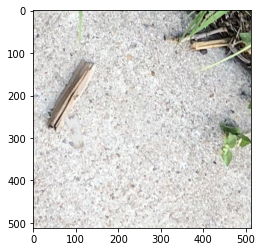

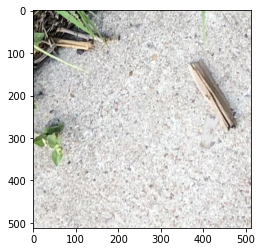

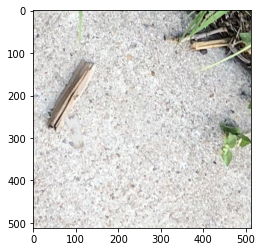

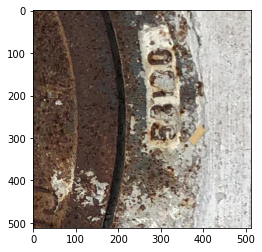

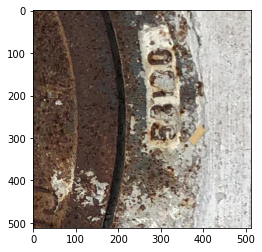

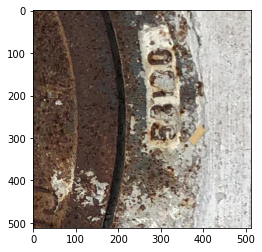

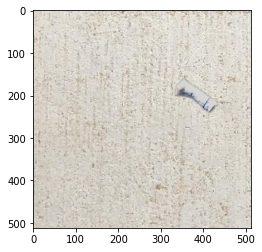

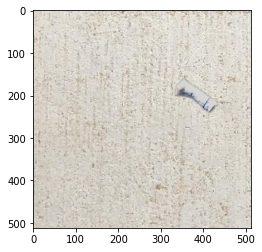

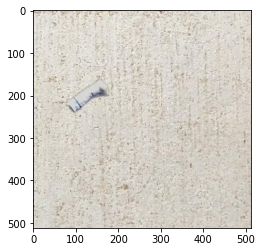

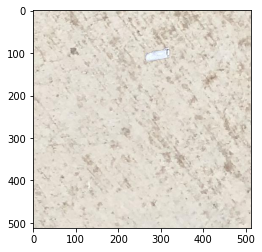

In [7]:
for i in range(10):
    img, target = dataset[i // 3 + 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [8]:
# train.evaluate(model, data_loader, device=device, printFunc=printProgress)   

In [9]:
# def engine_get_dice(target, pred, threshold=0.5): 
#     # print(src_targets)
#     target_mask_count = target['masks'].shape[0]
#     if target_mask_count == 0:
#         return 0
#     target_mask_sum = target['masks'][0].numpy()
#     for i in range(1, target_mask_count):
#         target_mask_sum += target['masks'][i].numpy()
#     target_mask = (target_mask_sum > 0)

#     # print(target_mask_sum.shape, np.where(target_mask))
#     print('engine_get_dice', 'target_mask.sum()', target_mask.sum(), pred['masks'].shape)
#     pred_mask_count = output['masks'].shape[0]
#     if pred_mask_count == 0:
#         return 0
        
#     intersection_sum = 0
#     im_sum = target_mask.sum()
#     preds = pred['masks'].numpy() > threshold
#     for mask_ind in range(pred_mask_count):
#         pred_mask = preds[mask_ind, 0]
#         print('pred_mask ', pred_mask.shape)
#         intersection_sum += (target_mask & pred_mask).sum()
#         im_sum += pred_mask.sum()
#     return 2.0 * intersection_sum / (im_sum + 1e-1)
        
# dices = engine.d
# np.mean(dices)
# print(type(np.mean(dices)))
# printProgress("Dices avg %.5f, all: %s" % (np.mean(dices), str(dices)))
# # engine_get_dice(engine.s, engine.p)
# # (engine.t[2]['masks'].shape)

In [10]:
num_epochs = 100

learnRate = 2e-3
for epoch in range(num_epochs):
    train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)   
    for g in optimizer.param_groups:
        g['lr'] = learnRate
    train.train_one_epoch(model, optimizer, data_loader, device, epochNum, 
                          print_freq=10, printFunc=printProgress)
    # train.train_one_epoch(model, train.criterion, optimizer, data_loader, lr_scheduler, device,
    #                       epochNum, print_freq=10)
    # lr_scheduler.step()
    
    epochNum += 1
    if epochNum % 5 == 0:
        save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
        save_model_state(model, (weights_file_name_templ % epochNum) + '_full') 
    # train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)    
    
    if epochNum % 15 == 0:
        learnRate /= 5    

creating index...
index created!


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Test:  [  0/200]  eta: 0:01:09  model_time: 0.1368 (0.1368)  evaluator_time: 0.0027 (0.0027)  time: 0.3453  data: 0.2025  max mem: 436
Test:  [100/200]  eta: 0:00:07  model_time: 0.0623 (0.0632)  evaluator_time: 0.0021 (0.0022)  time: 0.0705  data: 0.0034  max mem: 436
Test:  [199/200]  eta: 0:00:00  model_time: 0.0619 (0.0628)  evaluator_time: 0.0020 (0.0022)  time: 0.0703  data: 0.0034  max mem: 436
Test: Total time: 0:00:14 (0.0726 s / it)
Averaged stats: dice 0.95461, model_time: 0.0619 (0.0628)  evaluator_time: 0.0020 (0.0022)
Dices: [0.9690721649484214, 0.974949899799587, 0.9585605234459673, 0.728752849234765, 0.9753231492361545, 0.9795823665893044, 0.9758586361373697, 0.9313653136530677, 0.9569591950810241, 0.9627263045793055, 0.9751537515374914, 0.9807827184738255, 0.9698358151966214, 0.9734704926908369, 0.9625223081498917, 0.965212589729378, 0.9445378151260186, 0.9802271771140024, 0.9587628865979001, 0.9705022588360221, 0.9738791423001569, 0.9614337568057858, 0.977874186550933

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [34]  [  0/250]  eta: 0:11:12  lr: 0.002000  loss: 0.0841 (0.0841)  loss_classifier: 0.0058 (0.0058)  loss_box_reg: 0.0077 (0.0077)  loss_mask: 0.0704 (0.0704)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.6890  data: 1.2514  max mem: 5799
Epoch: [34]  [ 10/250]  eta: 0:04:31  lr: 0.002000  loss: 0.0795 (0.0786)  loss_classifier: 0.0056 (0.0056)  loss_box_reg: 0.0064 (0.0062)  loss_mask: 0.0673 (0.0666)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 1.1303  data: 0.1316  max mem: 6077


KeyboardInterrupt: ignored

# Анализ получившейся сети

Image 0 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.953, 0.969, 0.967, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 1 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.962, 0.975, 0.969, 0.897, masks: torch.Size([1, 1, 512, 512]), 1
Image 2 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.952, 0.959, 0.951, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 3 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.453, 0.469, 0.482, 0.491, 0.472, masks: torch.Size([2, 1, 512, 512]), 2
target bbox tensor([[162.,  46., 259.,  82.]])
Mask min 0.50, max 1.00, coords (246.0, 45.0), area 2404, target area 2243
target bbox tensor([[162.,  46., 259.,  82.]])
Mask min 0.50, max 1.00, coords (131.0, 105.0), area 1495, target area 2243


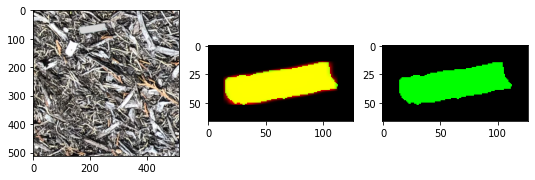

Image 4 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.949, 0.975, 0.981, 0.921, masks: torch.Size([1, 1, 512, 512]), 1
Image 5 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.967, 0.980, 0.958, 0.879, masks: torch.Size([1, 1, 512, 512]), 1
Image 6 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.959, 0.976, 0.979, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 7 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.901, 0.927, 0.931, 0.932, 0.887, masks: torch.Size([1, 1, 512, 512]), 1
target bbox tensor([[138., 220., 168., 256.]])
Mask min 0.51, max 1.00, coords (149.0, 220.0), area 689, target area 666


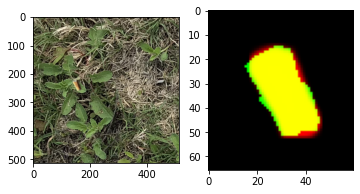

Image 8 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.945, 0.957, 0.955, 0.911, masks: torch.Size([1, 1, 512, 512]), 1
Image 9 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.943, 0.963, 0.957, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 10 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.952, 0.975, 0.976, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 11 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.920, 0.964, 0.981, 0.963, 0.885, masks: torch.Size([1, 1, 512, 512]), 1
Image 12 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.942, 0.970, 0.974, 0.948, masks: torch.Size([1, 1, 512, 512]), 1
Image 13 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.906, 0.957, 0.973, 0.950, 0.848, masks: torch.Size([1, 1, 512, 512]), 1
Image 14 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.950, 0.963, 0.960, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 15 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.898, 0.940, 0.965, 0.966, 0.905, masks: torch.Size([1, 1, 512, 512

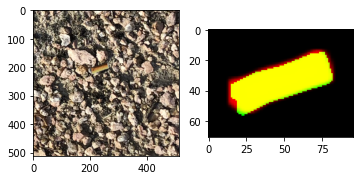

Image 17 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.944, 0.970, 0.980, 0.975, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
Image 18 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.926, 0.943, 0.959, 0.969, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 19 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.945, 0.971, 0.981, 0.939, masks: torch.Size([1, 1, 512, 512]), 1
Image 20 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.955, 0.974, 0.971, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 21 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.898, 0.943, 0.961, 0.955, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 22 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.934, 0.970, 0.978, 0.957, 0.882, masks: torch.Size([1, 1, 512, 512]), 1
Image 23 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.852, 0.927, 0.958, 0.919, 0.728, masks: torch.Size([1, 1, 512, 512]), 1
Image 24 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.944, 0.958, 0.955, 0.910, masks: torch.Size([1, 1, 512, 5

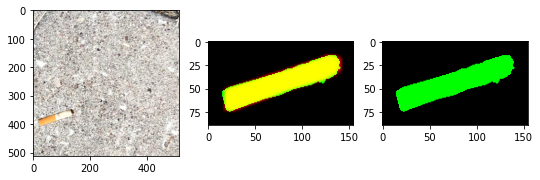

Image 34 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.927, 0.936, 0.934, 0.866, masks: torch.Size([1, 1, 512, 512]), 1
target bbox tensor([[106., 142., 159., 199.]])
Mask min 0.50, max 1.00, coords (125.0, 141.0), area 1293, target area 1270


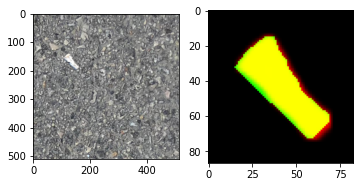

Image 35 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.442, 0.462, 0.477, 0.486, 0.469, masks: torch.Size([2, 1, 512, 512]), 2
target bbox tensor([[365., 343., 400., 413.]])
Mask min 0.50, max 1.00, coords (385.0, 342.0), area 1709, target area 1568
target bbox tensor([[365., 343., 400., 413.]])
Mask min 0.50, max 1.00, coords (189.0, 383.0), area 886, target area 1568


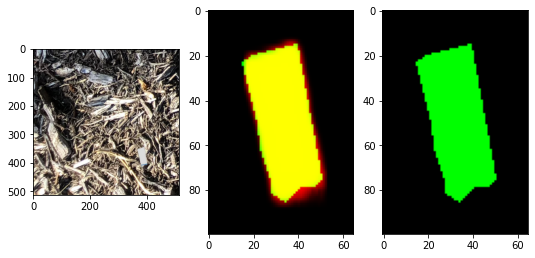

Image 36 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.917, 0.951, 0.969, 0.973, 0.925, masks: torch.Size([1, 1, 512, 512]), 1
Image 37 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.908, 0.948, 0.970, 0.970, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 38 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.943, 0.958, 0.960, 0.943, 0.879, masks: torch.Size([1, 1, 512, 512]), 1


In [ ]:
def show_pred_masks(dataset, img_idxs, plot_col_count,
                    log_thresholds, threshold_to_use_ind):
    """Runs model on the images, calculate dices on them on different thresholds
    and plot masks with dice < 0.95
    """

    model.eval()
    plot_row_count = 1
    dices = []
    with torch.no_grad():
        for img_idx2, img_idx in enumerate(img_idxs):
            img, target = dataset_test[img_idx]
            images = images_to_device(img, device)
            targets = targets_to_device(target, device)
            pred = model(images)
            masks = pred[0]['masks'].cpu()

            mask_count = masks.shape[0]
            cur_dices = []
            for threshold in log_thresholds:
                if mask_count != 0:
                    dice = get_dice(target['masks'][0].numpy().astype(bool),
                                    masks[0, 0].numpy() > threshold) / mask_count
                        # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
                else:
                    dice = 0
                cur_dices.append(dice)
            print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
                (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
            dices.append(cur_dices[threshold_to_use_ind])
            if cur_dices[threshold_to_use_ind] > 0.95:
                continue

            plt.figure(figsize=(12, 8))        
            zero_mask = np.zeros(list(masks.shape[2:]))
            mask_sum = np.copy(zero_mask)        
            for mask_ind in range(min(plot_col_count - 1, mask_count)):
                # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
                mask = masks[mask_ind, 0].numpy()
                where = np.where(mask > 0.5)
                # where = (where[0] , where[1] + 50)
                # mask[where] = 0.3
                target_where = np.where(target['masks'][0].numpy() > 0)
                # print('where', mask[where][:50])
                print('target bbox', target['boxes'])
                print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                    (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                    len(target_where[0])))
                # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
                mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
                mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

                
                bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
                ax = plt.subplot(plot_row_count, plot_col_count, mask_ind + 2)
                    # For plots matrix - also img_idx2 * plot_col_count + 
                im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
                # plt.colorbar(im, ax=ax)
            # print(mask_sum.shape, target['masks'].shape)
            # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
            ax = plt.subplot(plot_row_count, plot_col_count, 1)
            # im = ax.imshow(mask_sum)
            im = ax.imshow(np.transpose(img, (1, 2, 0)))

            # # Runs the entire evaluator on one image. But the results are non-visual
            # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
            # one_img_data_loader = torch.utils.data.DataLoader(
            #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
            #         collate_fn=collate_fn)
            # train.evaluate(model, one_img_data_loader, device=device)
            plt.show()
    return np.array(dices)

img_idxs = range(200)  
plot_col_count = 4
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
dices = show_pred_masks(dataset_test, img_idxs, plot_col_count,
                        log_thresholds, threshold_to_use_ind)

sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
# Had no time to fix for multiple objects
img_idxs = range(300)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 5
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
model.eval()
dices = []
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / mask_count
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        dices.append(cur_dices[threshold_to_use_ind])
        if cur_dices[threshold_to_use_ind] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        print('target bboxes', target['boxes'])
        pred_boxes = pred[0]['boxes'].cpu().numpy()
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, mask_count)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3

            target_mask_ind = find_nearest_bbox(pred_boxes[mask_ind], target['boxes'].numpy())
            print('pred', target['boxes'][target_mask_ind].numpy())
            bbox = expand_bbox(target['boxes'][target_mask_ind].numpy().astype(int), 15, mask.shape[-1])
            target_where = np.where(target['masks'][target_mask_ind].numpy() > 0)
            # print('where', mask[where][:50])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)
            
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb)  # [bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))

        # # Runs the entire evaluator on one image. But the results are non-visual
        # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
        # one_img_data_loader = torch.utils.data.DataLoader(
        #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
        #         collate_fn=collate_fn)
        # train.evaluate(model, one_img_data_loader, device=device)
        plt.show()

dices = np.array(dices)
sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Запись в pred_val_template.csv

# Данные, метрики и доступные функции

Посмотрим на данные:

In [ ]:
def show_images(data_path, img_ids):
    images = os.listdir(f"{data_path}/images")
    annotations = json.load(open(f"{data_path}/coco_annotations.json", "r"))
    for img_id in img_ids:
        img = None
        for ext in ['png', 'jpg', 'jpeg', 'gif']:
            img_path = f"{data_path}/images/{img_id:08}.{ext}"
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
        mask = utils.get_mask(img_id, annotations)  # [130:170, 270:350]
        show.show_img_with_mask(img, mask)
    return mask
    
mask = show_images(f"{data_root}/val", [3, 5])      # A couple of strange val. images

Пример подсчета метрики:

In [ ]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask), np.sum((mask > 0).astype(int)) / mask.size

// Можно для последовательности масок вычислить среднее значение метрики


Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [ ]:
rle_mask = encode_rle(mask)
rle_mask

# Сохранение результатов

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [40]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,171654 1 172158 1 172164 5 172670 3 172674 12 ...
1,1,171654 1 172158 1 172164 5 172670 3 172674 12 ...
2,2,171654 1 172158 1 172164 5 172670 3 172674 12 ...
3,3,171654 1 172158 1 172164 5 172670 3 172674 12 ...
4,4,171654 1 172158 1 172164 5 172670 3 172674 12 ...


0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


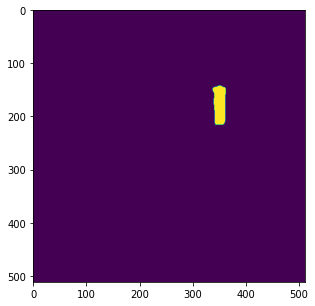

1 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


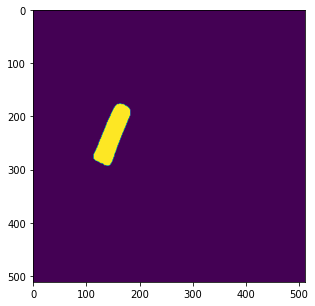

2 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


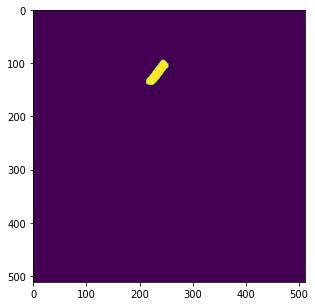

3 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


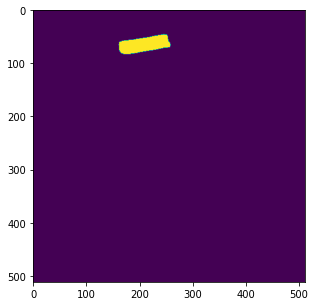

4 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


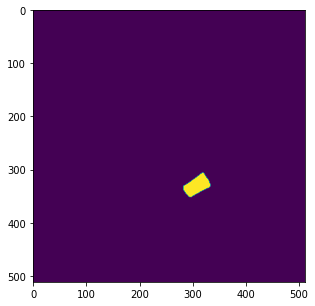

5 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


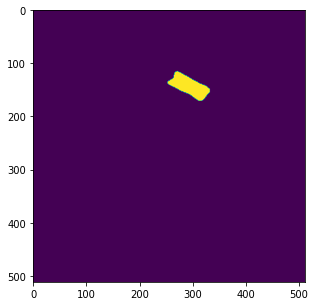

6 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


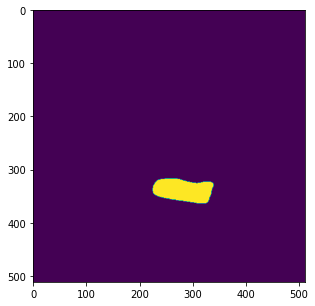

7 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


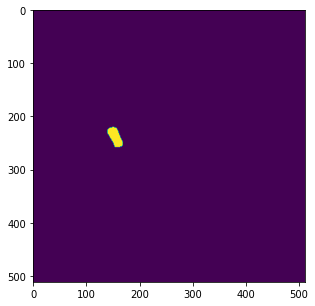

8 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


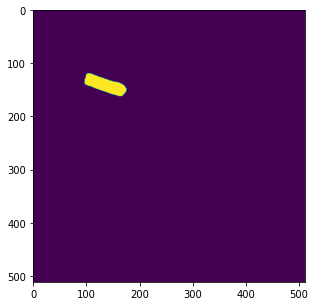

9 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


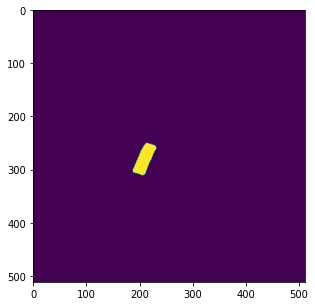

In [46]:
threshold = 0.5
pred_masks_by_id = {}
model.eval()
with torch.no_grad():
    for img_idx2, (img, target) in enumerate(dataset_test):
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu().numpy()

        mask_count = masks.shape[0]
        if mask_count == 0:
            raise Exception('No mask for image %d' % img_idx2)
             
        mask = masks[0, 0]
        mask2 = (mask > threshold).astype(np.uint8)
        mask2[mask2 > 0] = 255
        img_id = int(targets[0]['image_id'])
        pred_masks_by_id[img_id] = mask2
        if img_idx2 < 10:
            print(img_id, mask2)           
            
            plt.figure(figsize=(8, 5))        
            im = plt.imshow(mask2)
            plt.show()

In [47]:
fieldNames = ['img_id', 'rle_mask']
table = []
for img_id, mask in pred_masks_by_id.items():
    table.append((img_id, encode_rle(mask)))
data_frame = pd.DataFrame(table, columns=fieldNames)
data_frame.to_csv('results/pred_val_template.csv', index=False)

In [48]:
%ls -l results

total 865901
-rw------- 1 root root   1053503 Oct  4 10:23 CigHeadWeights_Epoch34.h5
-rw------- 1 root root 176227836 Oct  4 10:23 CigHeadWeights_Epoch34.h5_full
-rw------- 1 root root   1053503 Oct  5 15:35 CigHeadWeights_Epoch35.h5
-rw------- 1 root root 176227498 Oct  5 15:36 CigHeadWeights_Epoch35.h5_full
-rw------- 1 root root   1053503 Oct  5 15:30 CigHeadWeights_Epoch41.h5
-rw------- 1 root root 176227498 Oct  5 15:30 CigHeadWeights_Epoch41.h5_full
-rw------- 1 root root   1053503 Oct  5 08:02 CigHeadWeights_Epoch67.h5
-rw------- 1 root root 176227495 Oct  5 08:02 CigHeadWeights_Epoch67.h5_full
-rw------- 1 root root   1053499 Oct  5 14:05 CigHeadWeights_Epoch83.h5
-rw------- 1 root root 176227212 Oct  5 14:05 CigHeadWeights_Epoch83.h5_full
drwx------ 2 root root      4096 Oct  5 16:09 example/
-rw------- 1 root root       292 Oct  5 16:09 example.html
drwx------ 2 root root      4096 Oct  5 14:10 Old3/
-rw------- 1 root root    131951 Oct  5 16:21 pred_val_template.csv
-rw-----

In [39]:
val_annotations = json.load(open(f"{data_root}/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob(f"{data_root}/val/images/*"))
paths_to_imgs = paths_to_imgs[:10]
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
masks1 = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]
masks = [pred_masks_by_id[img_id] for img_id in sorted(img_ids)]

path_to_save = "results/example"
generate_images_for_html(paths_to_imgs, masks, path_to_save=path_to_save)     
generate_html(path_to_save)

mask = masks[0]
mask.shape, mask.dtype, mask.sum(), mask
encode_rle(mask)

'73054 5 73564 9 74072 15 74581 21 75092 23 75603 25 76115 25 76627 25 77139 25 77651 25 78164 24 78676 24 79189 23 79701 23 80214 22 80726 22 81238 22 81750 21 82262 21 82774 21 83286 21 83798 21 84310 21 84822 21 85333 22 85845 22 86357 22 86869 22 87381 22 87893 22 88405 22 88917 22 89429 22 89941 22 90453 22 90965 22 91478 21 91990 21 92502 21 93014 21 93526 21 94038 21 94550 21 95062 21 95574 21 96086 21 96598 21 97111 20 97623 20 98135 20 98647 20 99159 20 99671 20 100183 20 100695 20 101207 20 101719 20 102231 20 102743 20 103255 20 103767 20 104279 20 104791 20 105303 20 105815 20 106327 20 106839 20 107351 20 107863 19 108375 19 108887 19 109400 17 109912 16 110424 15'

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.